In [79]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Helper functions

- `imread`: Read an image from `img_path` and convert it to RGB
- `imshow`: Display the given `img` (`figsize` is optional figure size)
- `rgb2bin`: Convert the given RGB image `img_rgb` to binary
- `find_best_contour`: Find and return the largest contour in the image

In [80]:
def imread(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def imshow(img, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.show()
    
def rgb2bin(img_rgb):
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    t, img_bin = cv2.threshold(
        img_gray, 0, 255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV
    )
    return img_bin

def find_best_contour(img_rgb):
    img_bin = rgb2bin(img_rgb)
    contours, h = cv2.findContours(
        img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )
    best_contour = max(contours, key=cv2.contourArea)
    return best_contour

def draw_contours(img, contours, index=-1, color=(255, 0, 0), thickness=2):
    img_copy = img.copy()
    cv2.drawContours(img_copy, contours, index, color, thickness)
    imshow(img_copy)

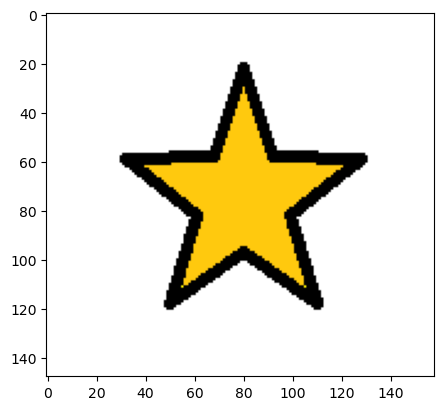

In [81]:
img = imread('images/star.png')
imshow(img)

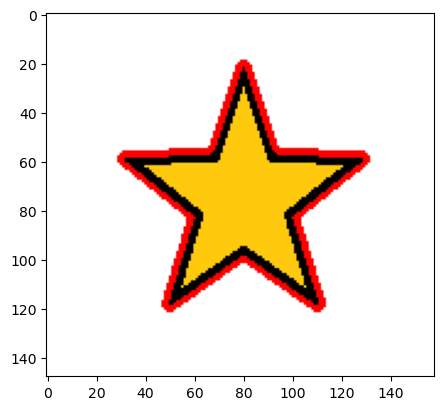

In [82]:
best_contour = find_best_contour(img)
draw_contours(img, best_contour)

# Chain code histogram

We loop through the best contour points to generate chain code like the following image. We find the chain code by calculating the difference in x (`dx`) and difference in y (`dy`) between each point and the next point.

<img src="images/chain-codes-diagram.png" alt="chian codes diagram" width="400"/>


We create a lookup table that maps between (`dx`, `dy`) and the chain code value according to the image above:
- Each key in the table is (`dx`, `dy`)
- The value is the chain code value

In [83]:
lookup_table = {
    (1, 0): 0,
    (1, -1): 1,
    (0, -1): 2,
    (-1, -1): 3,
    (-1, 0): 4,
    (-1, 1): 5,
    (0, 1): 6,
    (1, 1): 7
}

We can generate a histogram of chain codes by counting how many times each value appears in the chain code. The next cell will loop through points of the best contour to print the chain code and calculate the histogram.
- First, we initialize the histogram `hist` to zeros. The histogram has 8 values that represent the number of occurrences of each chain code value (from 0 to 7)
- After that, we loop through the points of the best contour (except the last point)
- Inside the loop, we store the current point (index `i`) in `pt1` and the next point (index `i+1`) in `pt2`
- We calculate `dx` and `dy` by subtracting the x and y values between `pt2` and `pt1`
- We give (`dx`, `dy`) to the lookup table to obtain the chain code value (we can print it if we want)
- We increment the histogram at the index of the chain code value `hist[code] += 1`

Outside the loop, we normalize the histogram by dividing it by the total sum: `hist/hist.sum()`. The normalized histogram will remain the same even if the object's size increases

In [84]:
import numpy as np

hist = np.zeros((8,))

for i in range(len(best_contour)-1):
    (x1, y1) = best_contour[i][0]
    (x2, y2) = best_contour[i+1][0]
    dx = x2 - x1
    dy = y2 - y1
    code = lookup_table[(dx, dy)]
    print(code, end='')
    hist[code] += 1

print("\n")
print(hist/hist.sum())

5665665665665665665665665665665665654444444444444444544444444444444444456677077770777707777077770777707566566566656656656656665665665666566700110110110111011011011101101100770770777077077077707707707700122232232232232223223223222322322322310111101111011110111101110111223444444444444444444344444444444444443232232232232232232232232232232232234

[0.09912536 0.12827988 0.14577259 0.07580175 0.20116618 0.07580175
 0.14577259 0.12827988]


We wrap what we did so far in a function that takes an RGB image `img_rgb` and returns the normalized histogram of chain codes. We can use this histogram as a feature descriptor for the image 

In [85]:
def chain_hist(img_rgb):

    best_contour = find_best_contour(img_rgb)
    lookup_table = {
        (1, 0): 0,
        (1, -1): 1,
        (0, -1): 2,
        (-1, -1): 3,
        (-1, 0): 4,
        (-1, 1): 5,
        (0, 1): 6,
        (1, 1): 7
    }

    hist = np.zeros((8,))
    for i in range(len(best_contour)-1):
        pt1 = best_contour[i][0]
        pt2 = best_contour[i+1][0]
        dx = pt2[0] - pt1[0]
        dy = pt2[1] - pt1[1]
        code = lookup_table[(dx, dy)]
        hist[code] += 1

    return hist/hist.sum()

In [86]:
print(chain_hist(img))

[0.09912536 0.12827988 0.14577259 0.07580175 0.20116618 0.07580175
 0.14577259 0.12827988]


# Using Support Vector Machine for shape classification
We use the normalized histograms of chain codes as features to train a Support Vector machine (SVM) classifier to classify the images of shapes (circle, square, star, rectangle)

We use the Four shapes dataset from kaggle [dataset link](https://www.kaggle.com/datasets/smeschke/four-shapes)

The next function takes the path to the data folder (`data_path`) and returns a DataFrame with two columns: image path, and output

## Creating a DataFrame for our dataset

In [87]:
import os
import pandas as pd

def create_df(data_path):
    
    # the class_dict is a mapping between class name and value
    class_dict = {
        'circle': 0,
        'square': 1,
        'star': 2,
        'triangle': 3
    }
    
    # we store image paths and outputs here
    df = []
    
    # for each class
    for class_name, class_value in class_dict.items():
        class_folder = os.path.join(data_path, class_name)
        # for each image in class folder
        for f in os.listdir(class_folder):
            f_path = os.path.join(class_folder, f)
            # if this is a "png" file, add its path and output
            if f_path.endswith('.png'):
              df.append([f_path, class_value])
    
    # create a dataframe of image paths and outputs
    df = pd.DataFrame(df, columns=['path', 'output'])
    
    return df

We use the previous function to read the data from the `shapes_dataset/` folder

In [88]:
data = create_df('shapes')
data

,path,output
0,shapes\circle\0 - Copy (10) - Copy - Copy.png,0
1,shapes\circle\0 - Copy (10) - Copy.png,0
2,shapes\circle\0 - Copy (10).png,0
3,shapes\circle\0 - Copy (100) - Copy - Copy.png,0
4,shapes\circle\0 - Copy (100) - Copy.png,0
...,...,...
16045,shapes\triangle\995.png,3
16046,shapes\triangle\996.png,3
16047,shapes\triangle\997.png,3
16048,shapes\triangle\998.png,3


## Extracting features

We loop through image paths to read each image and extract features from it using our `chain_hist` function. We store all images' features in an array `X` and return it

In [89]:
from tqdm import tqdm

def extract_features(img_paths):
    n = len(img_paths)
    X = np.zeros((n, 8))
    for i in tqdm(range(n)):
        f_path = img_paths[i]
        img = imread(f_path)
        features = chain_hist(img)
        X[i] = features
    return X

In [90]:
X = extract_features(data['path'])

100%|██████████| 16050/16050 [02:07<00:00, 125.60it/s]


We store outputs in `y`

In [91]:
y = data['output']

## Splitting dataset

We split the data to train and test sets

In [92]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

## Training

We train our Support vector machine

In [93]:
from sklearn.svm import SVC

In [94]:
model = SVC()
model.fit(X_train, y_train)

SVC()

## Calculating accuracy

We print the accuracy of train and test

In [95]:
from sklearn.metrics import accuracy_score

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

0.9647530040053405
0.9626168224299065


## Testing with images outside the dataset

We test the model with images outside the dataset

In [96]:
def test_model(model, img_path):
    classes = ['circle', 'square', 'star', 'triangle']
    img = imread(img_path)
    x = chain_hist(img)
    c = model.predict([x])[0]
    print(img_path, '->', classes[c])

In [97]:
def test_model2(model, img):
    classes = ['circle', 'square', 'star', 'triangle']
    x = chain_hist(img)
    c = model.predict([x])[0]
    print(classes[c])
    return classes[c]

In [99]:
test_model(model, 'images/Square.png')
test_model(model, 'images/star.png')
test_model(model, 'images/triangle.png')
test_model(model, 'images/square-hollow.png')
test_model(model, 'images/star-hollow.png')
test_model(model, 'images/circle-hollow.png')
test_model(model, 'images/triangle-hollow.png')

images/Square.png -> square
images/star.png -> star
images/triangle.png -> triangle
images/square-hollow.png -> square
images/star-hollow.png -> star
images/circle-hollow.png -> circle
images/triangle-hollow.png -> triangle


# Object detection example

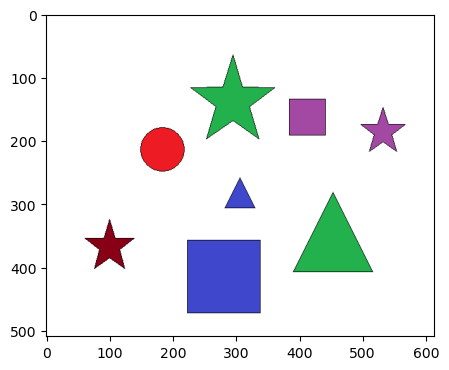

In [101]:
img = imread('shapes.png')
imshow(img)

# Other feature descriptors
The method we used is very simple and won't work for complex objects (such as cats). If we want to deal with complex objects, we should use a better feature descriptor. Examples include:
- SIFT (Scale-Invariant Feature Transform)
- SURF (Speeded-Up Robust Features)
- LBP (Local Binary Patterns)
- HOG (Histogram Oriented Gradients)
- Deep-learning based:
  - Auto encoders
  - Pre-trained models such as ResNet, etc.

In [110]:
def detect_connected_components(img_rgb,w_range=None,h_range=None):
    # convert image to gray
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    # convert gray image to binary
    t, img_bin = cv2.threshold(img_gray,0,255,cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
    # detect connected components
    components = cv2.connectedComponentsWithStats(img_bin,connectivity=4)
    (nLabels, labels, stats, centroids) = components
    centroids = centroids.astype(int)
    # copy image to avoid drawing on the original image
    img = img_rgb.copy()    
    # loop through components
    for i in range(1, nLabels):
        x, y, w, h, area = stats[i]
        (cx, cy) = centroids[i]   
        # by default, there is no limit for width or height
        acceptWidth = True
        acceptHeight = True
        # check the width, and height are within range (if defined)
        if w_range:
            acceptWidth = (w > w_range[0] and w < w_range[1])
        if h_range:
            acceptHeight = (h > h_range[0] and h < h_range[1])
        # draw location if width and height are accepted
        if acceptWidth and acceptHeight:
            cut_image=img[y:y+h,x:x+w]
            imshow(cut_image)

            nameOfShape=test_model2(model,cut_image)
            cv2.rectangle(img, (x, y), (x+w, y+h), (0,0, 0), 2)
            
            cv2.putText(img, nameOfShape, (x, y-8),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0,0),1)

    
    imshow(img, figsize=(10, 10))

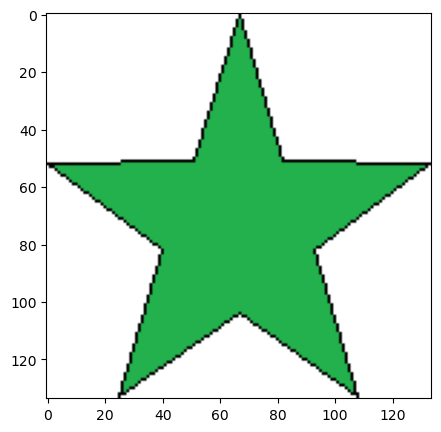

star


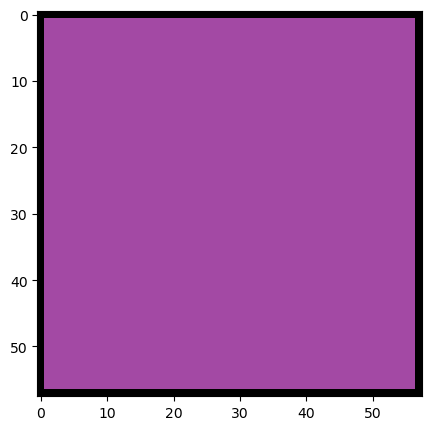

square


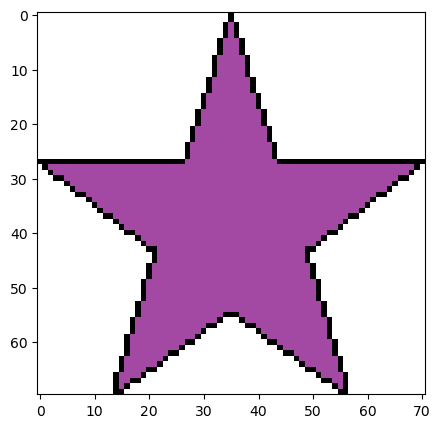

star


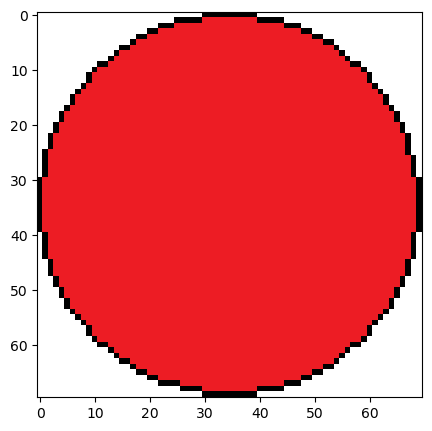

circle


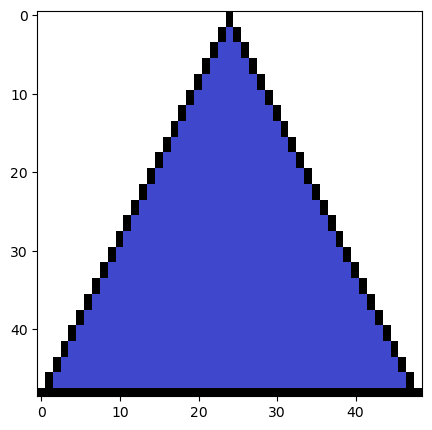

triangle


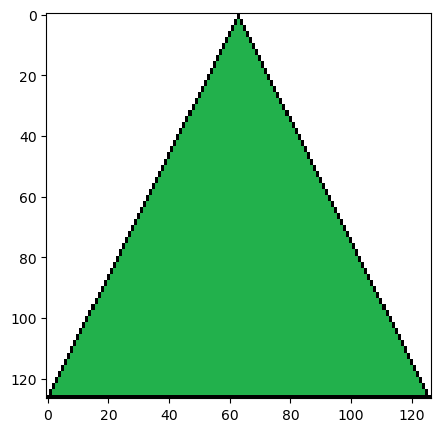

triangle


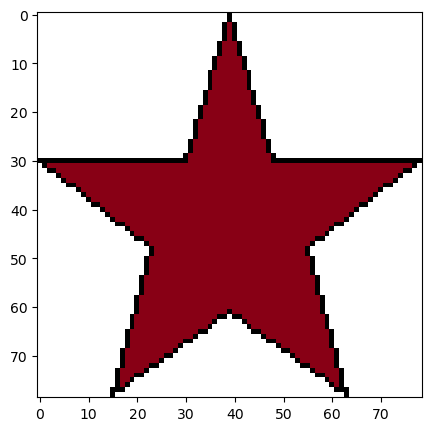

star


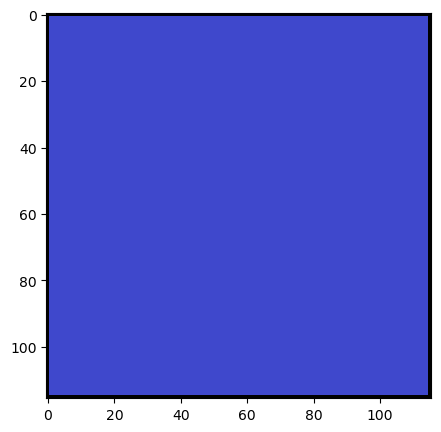

square


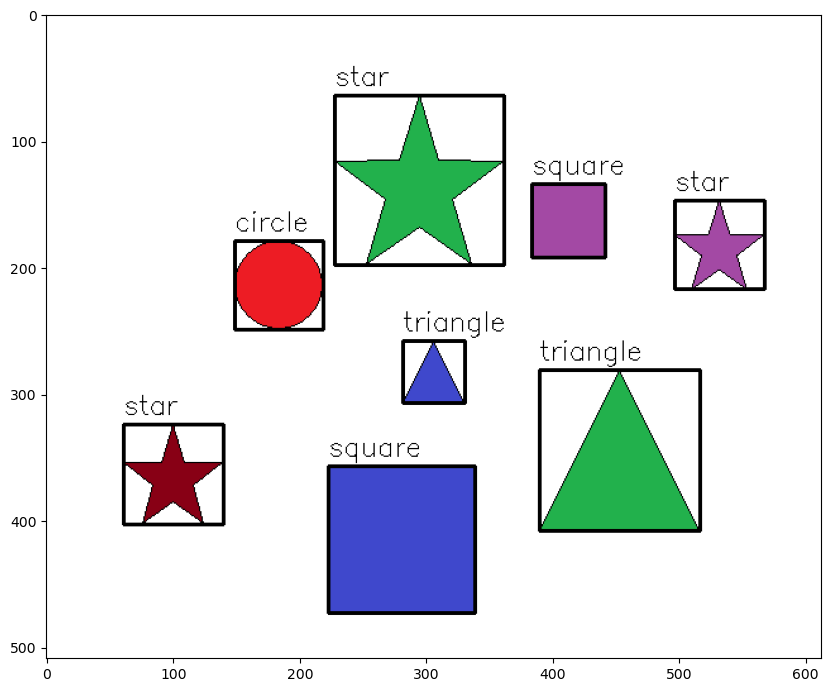

In [111]:
detect_connected_components(img, w_range=(15, 135),h_range=(20, 135))